In [ ]:
from pathlib import Path

In [ ]:
real_root = "D:/data/aia_dataset"
real_root = Path(real_root)
stage = "test"
input_files = sorted(list((real_root / stage / "input").glob("*.npz")))
target_files = sorted(list((real_root / stage / "target").glob("*.npz")))

print(len(input_files), len(target_files))

244 244


In [ ]:
import yaml

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sunpy.map import Map
from astropy.visualization import ImageNormalize, AsinhStretch

norm171 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.02))
norm304 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.005))
norm193 = ImageNormalize(vmin=0, vmax=2000, stretch=AsinhStretch(0.04))

In [ ]:
import sys
sys.path.append(r"D:\workspace\image-to-image\notebooks\diffusion")

from networks import define_model
from noise_schedule import get_beta_schedule
from sampling import compute_alpha
from img2img.data.preprocess.sdo.preprocess_aia import NormalizeEditor

def inverse(x):
    x = NormalizeEditor(0, 14).inverse(x)
    return x

In [ ]:
diffusion_model = "E:/home/mgjeon/image-to-image/results/sdo/diffusion/ddpm_x0/logs/version_0/checkpoints/49_48249_ema.pth"
diffusion_config = "E:/home/mgjeon/image-to-image/results/sdo/diffusion/ddpm_x0/logs/version_0/checkpoints/config.yaml"
diffusion_hparams = "E:/home/mgjeon/image-to-image/results/sdo/diffusion/ddpm_x0/logs/version_0/hparams.yaml"

with open(diffusion_config) as f:
    model_cfg = yaml.safe_load(f)

with open(diffusion_hparams) as file:
    cfg = yaml.safe_load(file)
    if cfg.get('cfg') is not None:
        cfg = cfg['cfg']  
    data = cfg['data']
    params = cfg['params']
    
model = define_model(model_cfg)
model_pth = torch.load(diffusion_model, map_location=device, weights_only=True)
model.load_state_dict(model_pth)
model = model.to(device)

In [ ]:
# idx = 14
idx = 44
# idx = 105
# idx = 166
# idx = 227
input_file = input_files[idx]
target_file = target_files[idx]
print(input_file.stem, target_file.stem)

2020-10-15T00-00-00_171_304 2020-10-15T00-00-00_193


In [ ]:
timestamp = input_file.stem[:-8]
timestamp

'2020-10-15T00-00-00'

In [ ]:
image_size = 1024
input_image = np.load(input_file)['data'].astype(np.float32).transpose(1, 2, 0)
target_image = np.load(target_file)['data'].astype(np.float32).transpose(1, 2, 0)
transform = A.Compose([
                A.Resize(image_size, image_size),
                ToTensorV2(),
            ], 
                additional_targets = {
                    'image_target': 'image',
                }
            )
transformed = transform(image=input_image, image_target=target_image)
input_image = transformed["image"].unsqueeze(0).to(device)
target_image = transformed["image_target"].unsqueeze(0).to(device)
print(input_image.shape, target_image.shape)

torch.Size([1, 2, 1024, 1024]) torch.Size([1, 1, 1024, 1024])


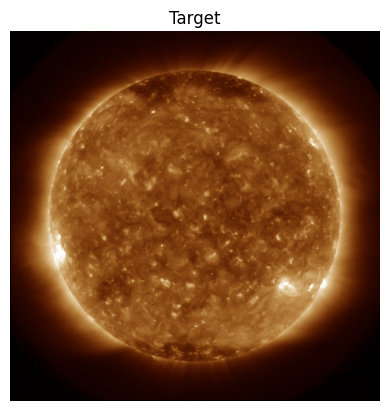

In [ ]:
target_meta = np.load(target_file, allow_pickle=True)['metas'][0]
target_data = target_image[0].cpu().numpy()
target_map = Map(target_data, target_meta)
target_map = inverse(target_map)
plt.imshow(target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
plt.axis("off")
plt.title("Target")
plt.show()

In [ ]:
num_timesteps = 1000
betas = get_beta_schedule(
    beta_schedule=params['diffusion']['beta_schedule'],
    beta_start=params['diffusion']['beta_start'],
    beta_end=params['diffusion']['beta_end'],
    num_diffusion_timesteps=num_timesteps
)
betas = torch.from_numpy(betas).float().to(device)
alphas = (1-betas).cumprod(dim=0)

t = torch.LongTensor([0, 300, 400, 500, 600, 700, 999]).to(device)
a = alphas.index_select(dim=0, index=t).view(-1, 1, 1, 1)

e = torch.randn_like(target_image)
e = e.clamp(-1, 1)
xt = target_image*a.sqrt() + e*(1.0 - a).sqrt()
xt = xt.cpu().numpy()
xt.shape

(7, 1, 1024, 1024)

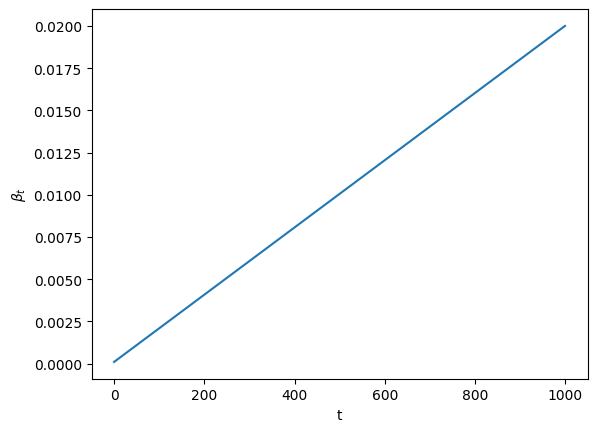

In [ ]:
plt.figure()
plt.plot(betas.cpu().numpy())
plt.xlabel("t")
plt.ylabel(r"$\beta_t$")
plt.show()


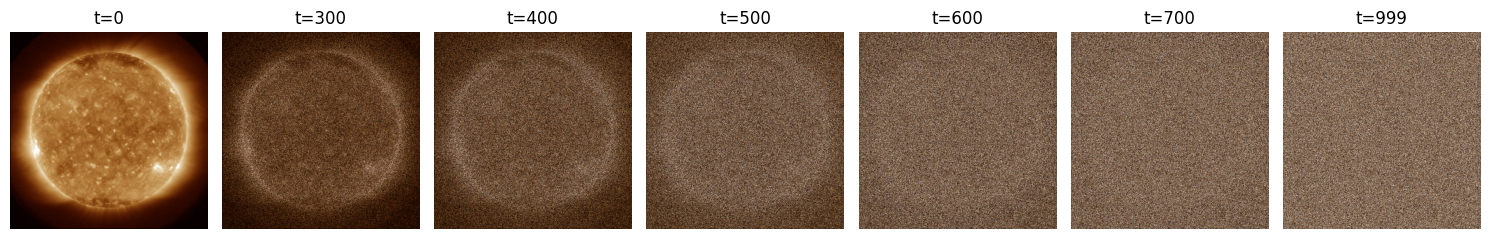

In [ ]:
def draw_images(t, imgs, metas, figsize=(15, 5)):
  num_cols = imgs.shape[0]
  fig, axs = plt.subplots(figsize=figsize, ncols=num_cols)
  for i, ax in enumerate(axs):
    t_map = Map(imgs[i][0], metas)
    t_map = inverse(t_map)
    norm = ImageNormalize(vmin=0, vmax=t_map.data.max()/3, stretch=AsinhStretch(0.01))
    ax.imshow(t_map.data, cmap="sdoaia193", origin="lower", norm=norm)
    ax.axis('off')
    ax.set_title(f"t={t[i]}")
  plt.tight_layout()
  plt.show()

target_meta = np.load(target_file, allow_pickle=True)['metas'][0]
draw_images(t, xt, target_meta)

(np.float64(-0.5), np.float64(1023.5), np.float64(-0.5), np.float64(1023.5))

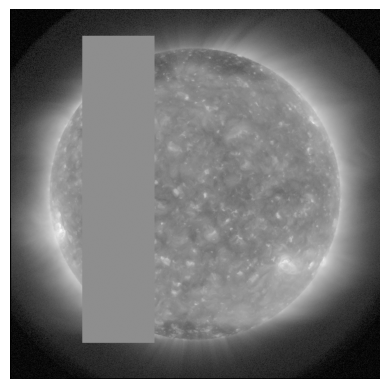

In [ ]:
mask = np.ones_like(target_image.cpu().numpy()[0,0])
mask[100:950, 200:400] = 0
plt.imshow(target_image.cpu().numpy()[0,0]*mask, cmap="gray", origin="lower")
plt.axis("off")

In [ ]:
mask = torch.from_numpy(mask).float().to(device).unsqueeze(0).unsqueeze(0)
mask.shape

torch.Size([1, 1, 1024, 1024])

In [ ]:
x_input = input_image.to(device)
x_0 = target_image.to(device)
n = x_input.shape[0]

xt = torch.randn(
        n,
        cfg['model']['args']['out_channels'],
        data['image_size'],
        data['image_size'],
        device=device
)
xt = xt.clamp(-1, 1)

num_timesteps = 1000
timesteps = 10
betas = get_beta_schedule(
    beta_schedule=cfg['params']['diffusion']['beta_schedule'],
    beta_start=cfg['params']['diffusion']['beta_start'],
    beta_end=cfg['params']['diffusion']['beta_end'],
    num_diffusion_timesteps=num_timesteps
)
betas = torch.from_numpy(betas).float().to(device)

skip = num_timesteps // timesteps
# seq = range(-1, num_timesteps, skip)
# seq = list(seq)
# seq[0] = 0
seq = range(0, num_timesteps, skip)
print(list(seq))

seq_next = [-1] + list(seq[:-1])
eta = cfg['params']['sampling'].get('eta', 0.0)
pred_type = cfg['params']['pred']
print(f"eta: {eta}")

xs = [xt]
x0_preds = []

ts = [list(seq)[-1]]
t0 = []

model.eval()
with torch.no_grad():
    for i, j in zip(tqdm(reversed(seq)), reversed(seq_next)):
        t = (torch.ones(n) * i).to(device)
        t_next = (torch.ones(n) * j).to(device)
        at = compute_alpha(betas, t.long())
        at_next = compute_alpha(betas, t_next.long())

        xt = xs[-1].to(device)

        if pred_type == 'noise':
            et = model(torch.cat([x_input, xt], dim=1), t)
            x0_t = (xt - et*(1.0 - at).sqrt()) / at.sqrt()

        elif pred_type == 'x0':
            x0_t = model(torch.cat([x_input, xt], dim=1), t)
            et = (xt - x0_t*at.sqrt()) / (1.0 - at).sqrt()

        x0_preds.append(x0_t.to('cpu')) 
        t0.append(int(t.cpu().item()))

        # direction pointing to x_t
        # eta = 0 : DDIM (c1=0)
        # eta = 1 : DDPM (c1!=0)
        c1 = (
                eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt()
        )
        c2 = ((1 - at_next) - c1 ** 2).sqrt()

        xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(xt) + c2 * et
        xt_next = xt_next.clamp(-1, 1)

        e = torch.randn_like(xt) if i != 0 else 0
        xt_known_next = at_next.sqrt() * x_0 + (1.0 - at_next).sqrt() * e
        xt_known_next = xt_known_next.clamp(-1, 1)

        xt_next = mask * xt_known_next + (1 - mask) * xt_next

        xs.append(xt_next.to('cpu'))
        ts.append(int(t_next.cpu().item()))

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
eta: 0.0


0it [00:00, ?it/s]

10it [00:01,  6.65it/s]


In [ ]:
# for i, j in zip(tqdm(reversed(seq)), reversed(seq_next)):
#     t = (torch.ones(n) * i).to(device)
#     t_next = (torch.ones(n) * j).to(device)
#     at = compute_alpha(betas, t.long())
#     at_next = compute_alpha(betas, t_next.long())
#     print(t.squeeze().cpu(), t_next.squeeze().cpu())
#     print(at.squeeze().cpu(), at_next.squeeze().cpu())
#     print()

In [ ]:
def get_images(imgs, metas):
    ims = []
    for i in range(len(imgs)):
        data = imgs[i][0].cpu().numpy()
        data = np.clip(data, -1, 1)
        t_map = Map(data, metas)
        t_map = inverse(t_map)
        ims.append(t_map.data)
    return ims

In [ ]:
target_meta = np.load(target_file, allow_pickle=True)['metas'][0]
xs_imgs = get_images(xs, target_meta)
x0_preds_imgs = get_images(x0_preds, target_meta)

In [ ]:
# def draw_images_list(t, imgs, figsize=(15, 5)):
#   num_cols = len(imgs)
#   fig, axs = plt.subplots(figsize=figsize, ncols=num_cols)
#   for i, ax in enumerate(axs):
#     norm = ImageNormalize(vmin=0, vmax=np.max(imgs[i])/3, stretch=AsinhStretch(0.04))
#     ax.imshow(imgs[i], cmap="sdoaia193", origin="lower", norm=norm)
#     ax.axis('off')
#     ax.set_title(f"t={t[i]}")
#   plt.tight_layout()
#   plt.show()

# draw_images_list(ts, xs_imgs)
# draw_images_list(t0, x0_preds_imgs)

2025-01-10 11:11:32 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-01-10 11:11:32 - matplotlib.animation - INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -framerate 10.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y 2020-10-15T00-00-00_ddpm_x0_ema_mask.gif


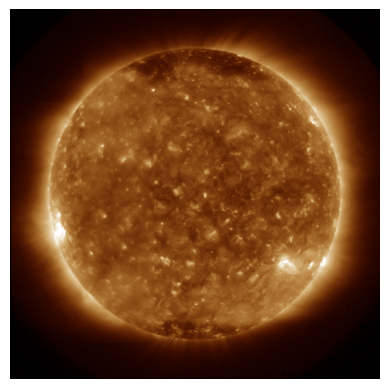

In [ ]:
import matplotlib.animation as animation

def draw_images_list_ani(imgs, metas):
    fig = plt.figure()
    ims = []
    for i in range(len(imgs)):
        norm = ImageNormalize(vmin=0, vmax=np.max(imgs[i])/3, stretch=AsinhStretch(0.04))
        im = plt.imshow(imgs[i], cmap="sdoaia193", origin="lower", norm=norm)
        plt.axis('off')
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=100, blit=True)
    return animate
  
animate = draw_images_list_ani(xs_imgs, target_meta)
animate.save(f'{timestamp}_ddpm_x0_ema_mask.gif')

# animate = draw_images_list_ani(x0_preds_imgs, target_meta)
# animate.save(f'{timestamp}_ddpm_x0_ema_x0.gif')

In [ ]:
from torchmetrics import MeanAbsoluteError
from torchmetrics.regression import PearsonCorrCoef
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

In [ ]:
mae = MeanAbsoluteError()                 # 0.0 is best
psnr = PeakSignalNoiseRatio()             # +inf is best
ssim = StructuralSimilarityIndexMeasure() # 1.0 is best
pearson = PearsonCorrCoef()               # 1.0 is best

In [ ]:
fake_root = "/home/mgj/workspace/mgjeon/image-to-image/metrics/sdo/pix2pixCC/default_small_ema/version_0"
fake_file = Path(fake_root) / stage / (str(target_file.stem) + "_fake.npz")
fake = np.load(fake_file, allow_pickle=True)
fake_map = Map(fake["data"][0], fake["metas"][0])
fake_map = inverse(fake_map)
fake_data = fake_map.data
fake_data.shape

FileNotFoundError: [Errno 2] No such file or directory: '\\home\\mgj\\workspace\\mgjeon\\image-to-image\\metrics\\sdo\\pix2pixCC\\default_small_ema\\version_0\\test\\2020-10-15T00-00-00_193_fake.npz'

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

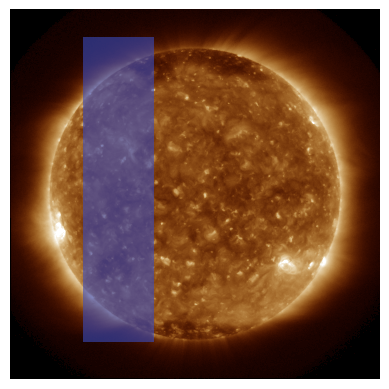

In [ ]:
plt.imshow(target_map.data, cmap="sdoaia193", origin="lower", norm=norm193)
masking = mask.cpu().numpy()[0,0]
masking = np.where(masking==1, np.nan, masking)
plt.imshow(masking, alpha=0.6, cmap="coolwarm", origin="lower")
plt.axis("off")
plt.show()

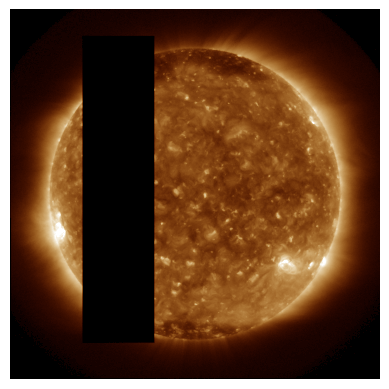

In [ ]:
masking = mask.cpu().numpy()[0,0]
plt.imshow(target_map.data*masking, cmap="sdoaia193", origin="lower", norm=norm193)
plt.axis("off")
plt.savefig(f"{timestamp}_mask.png", bbox_inches="tight", pad_inches=0)
plt.show()

<matplotlib.image.AxesImage>

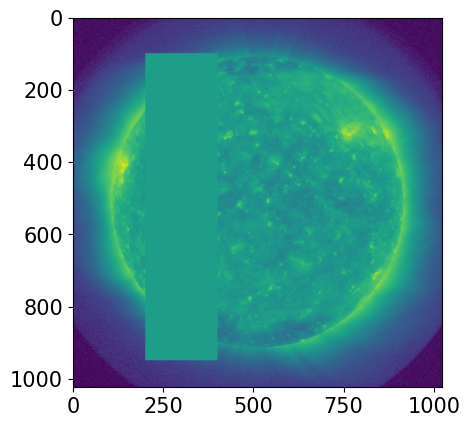

In [ ]:
plt.imshow(target_image.cpu().numpy()[0,0]*mask.cpu().numpy()[0,0])

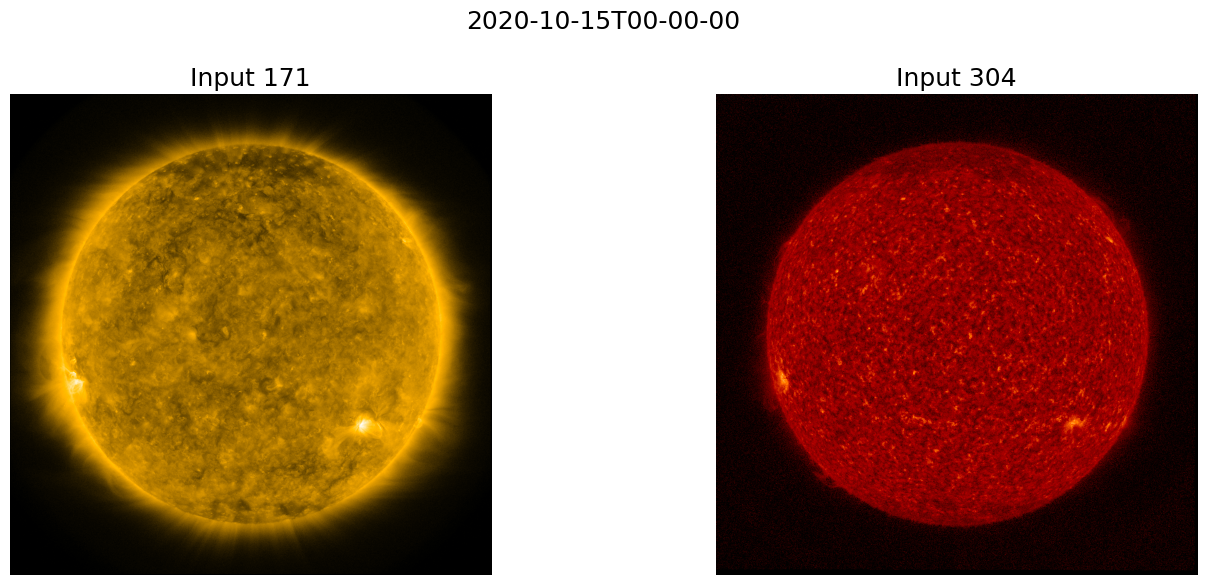

In [ ]:
input_meta = np.load(input_file, allow_pickle=True)['metas']
input_map_171 = Map(input_image[0,0].cpu().numpy(), input_meta[0])
input_map_304 = Map(input_image[0,1].cpu().numpy(), input_meta[1])
input_map_171 = inverse(input_map_171)
input_map_304 = inverse(input_map_304)

plt.rcParams["font.size"] = 15

fig = plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(input_map_171.data, cmap="sdoaia171", origin="lower", norm=norm171)
ax1.axis("off")
ax1.set_title("Input 171")

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(input_map_304.data, cmap="sdoaia304", origin="lower", norm=norm304)
ax2.axis("off")
ax2.set_title("Input 304")

fig.suptitle(f"{timestamp}")
plt.tight_layout()
fig.savefig(f"{timestamp}_input.png")
plt.show()

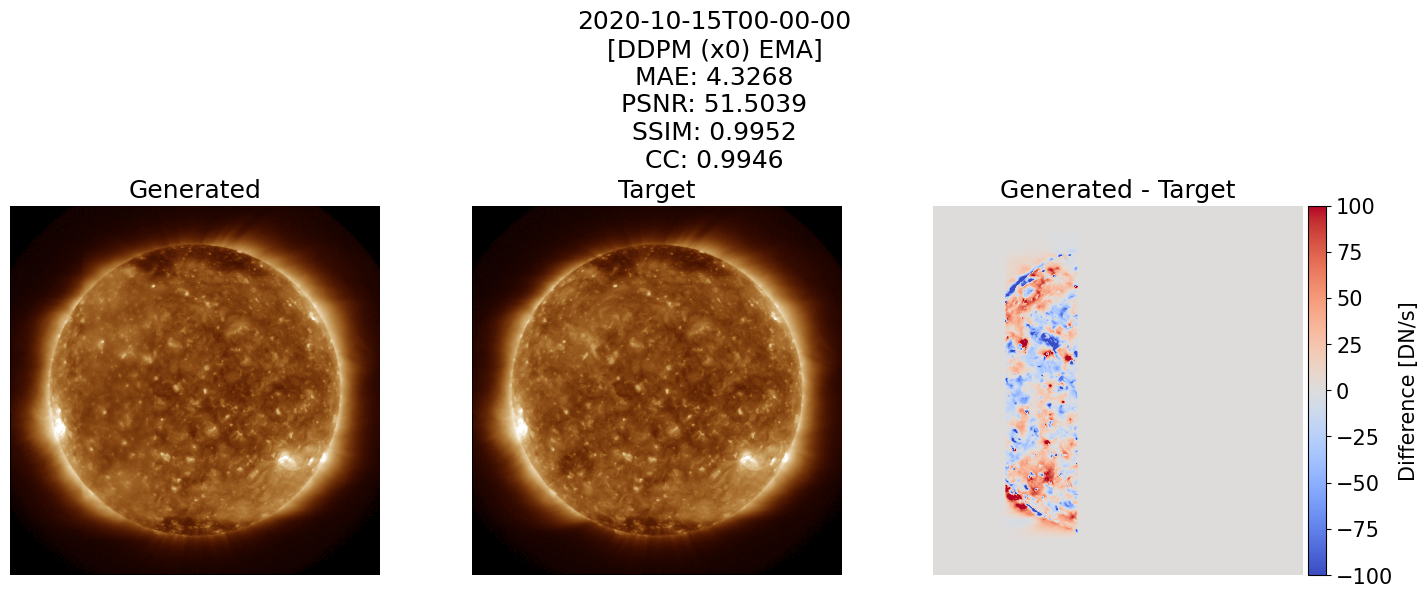

In [ ]:
# pred_image = xs_imgs[-1]

# for pred_image in x0_preds_imgs:
pred_image = xs_imgs[-1]
target_image = target_map.data


pred_img = torch.from_numpy(pred_image)[None, None, ...]
target_img = torch.from_numpy(target_image)[None, None, ...]
mae_value = mae(pred_img, target_img)
psnr_value = psnr(pred_img, target_img)
ssim_value = ssim(pred_img, target_img)
pearson_value = pearson(pred_img.flatten(), target_img.flatten())





fig = plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(pred_image, cmap="sdoaia193", origin="lower", norm=norm193)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.axis("off")
ax1.axis("off")
ax1.set_title("Generated")

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(target_image, cmap="sdoaia193", origin="lower", norm=norm193)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.axis("off")
ax2.axis("off")
ax2.set_title("Target")

ax3 = plt.subplot(1, 3, 3)
im = ax3.imshow(pred_image - target_image, cmap="coolwarm", origin="lower",
                vmin=-100, vmax=100)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation="vertical")
cbar.set_label("Difference [DN/s]")
ax3.axis("off")
ax3.set_title("Generated - Target")

fig.suptitle(f"{timestamp}\n[DDPM (x0) EMA]\nMAE: {mae_value:.4f}\nPSNR: {psnr_value:.4f}\nSSIM: {ssim_value:.4f}\nCC: {pearson_value:.4f}")

plt.tight_layout()
plt.savefig(f"{timestamp}_ddpm_x0_ema_mask.png")
plt.show()